In [1]:
import numpy as np
import healpy as hp
import itertools
import jax.numpy as jnp
from jax import vmap, grad
from response import pairwise_monopole, pairwise_dipole, vvec
from jax import config
# config.update("jax_enable_x64", True)

# plot settings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font = {'size'   : 18, 'family':'Latin Modern Roman'}
axislabelfontsize='large'
# matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# matplotlib.rc('text', usetex=True)
# matplotlib.rc('font', size=20)
# matplotlib.rc('legend', fontsize=18)
# matplotlib.rc('text.latex', preamble=r'\usepackage{lmodern}')

In [2]:
get_vec = lambda theta,phi: jnp.array([jnp.sin(theta)*jnp.cos(phi),jnp.sin(theta)*jnp.sin(phi),jnp.cos(theta)])

pi_3 = np.pi/3
pi_4 = np.pi/4
n1 = get_vec(pi_3,pi_3)
n2 = get_vec(pi_4,pi_4)

nside = 32
npix = hp.nside2npix(nside)
pix = np.arange(npix)
print(n1.shape,pix.shape)

pvec_array = np.array(hp.pix2vec(nside,pix)).T

print(np.shape(pvec_array))

monopole = pairwise_monopole(n1,n2,pvec_array,nside)

print(monopole.shape)

print(monopole)

print(jnp.trace(monopole))

(3,) (12288,)
(12288, 3)
(3, 3)
[[ 1.3277693  -0.6614911  -0.47112978]
 [-0.38783485  0.9871325  -0.42376754]
 [-0.56812966 -0.907831    1.0436618 ]]
3.3585637


In [3]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

theta, phi = (np.pi/2,0)
n1 = get_vec(theta,phi)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

f = lambda q: jnp.trace(pairwise_monopole(n1,q,pvec_array,nside))
map_stars_dij = vmap(f)(stars_vec)

print(map_stars_dij.shape)

f = lambda q: jnp.einsum("i...,j...,ij...->...",q,n1,pairwise_monopole(n1,q,pvec_array,nside))
map_stars_qinj = vmap(f)(stars_vec)

print(map_stars_qinj.shape)


f = lambda q: jnp.trace(jnp.square(pairwise_monopole(n1,q,pvec_array,nside)))
map_stars_sq = vmap(f)(stars_vec)

print(map_stars_sq.shape)

(768, 3)
(768,)
(768,)
(768,)


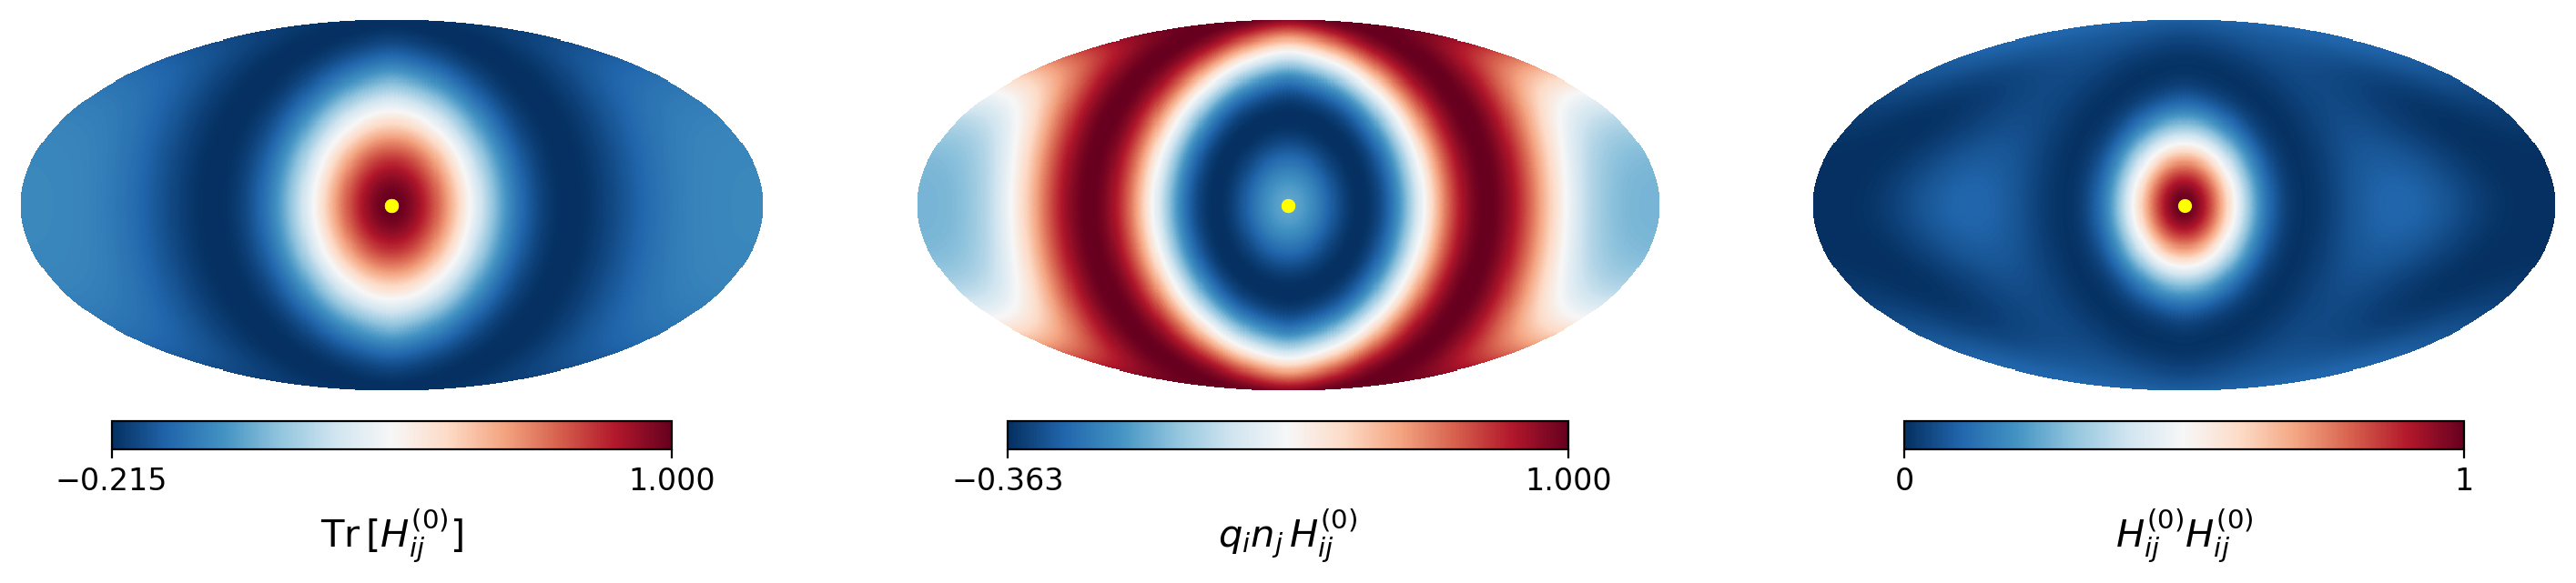

In [4]:

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,4))

cmap = 'RdBu_r'

fwhm = 0.2

# delta_ij H_ij
sm = map_stars_dij
up_map = hp.ud_grade(map_stars_dij,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax1)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,color='yellow',s=20)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathrm{Tr}\,[H^{(0)}_{ij}]$',size=15)

# q_i n_j H_ij
sm = map_stars_qinj
up_map = hp.ud_grade(map_stars_qinj,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax2)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,color='yellow',s=20)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$q_i n_j\,H^{(0)}_{ij}$',size=15)

# H_ij H_ij
sm = map_stars_sq
up_map = hp.ud_grade(map_stars_sq,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax3)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,color='yellow',s=20)
f = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$H^{(0)}_{ij}H^{(0)}_{ij}$',size=15)

plt.savefig('monopole.pdf',bbox_inches='tight')

In [5]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

theta, phi = (np.pi/2,0)
n1 = get_vec(theta,phi)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

f = lambda q: jnp.trace(pairwise_dipole(n1,q,pvec_array,nside))
map_stars_dij_center = vmap(f)(stars_vec)
print(map_stars_dij_center.shape)


theta0 = np.pi/2 - np.deg2rad(48)
phi0 = np.deg2rad(264)
n1 = get_vec(theta0,phi0)

#f = lambda q: jnp.trace(pairwise_dipole(n1,q,pvec_array,nside)) # For the Trace of Hij
f = lambda q: jnp.einsum("i...,j...,ij...->...",q,n1,pairwise_dipole(n1,q,pvec_array,nside))
map_stars_dij_v = vmap(f)(stars_vec)

print(map_stars_dij_v.shape)


f = lambda q: jnp.trace(jnp.square(pairwise_dipole(n1,q,pvec_array,nside)))
map_stars_sq = vmap(f)(stars_vec)

print(map_stars_sq.shape)




(768, 3)
(768,)
(768,)
(768,)


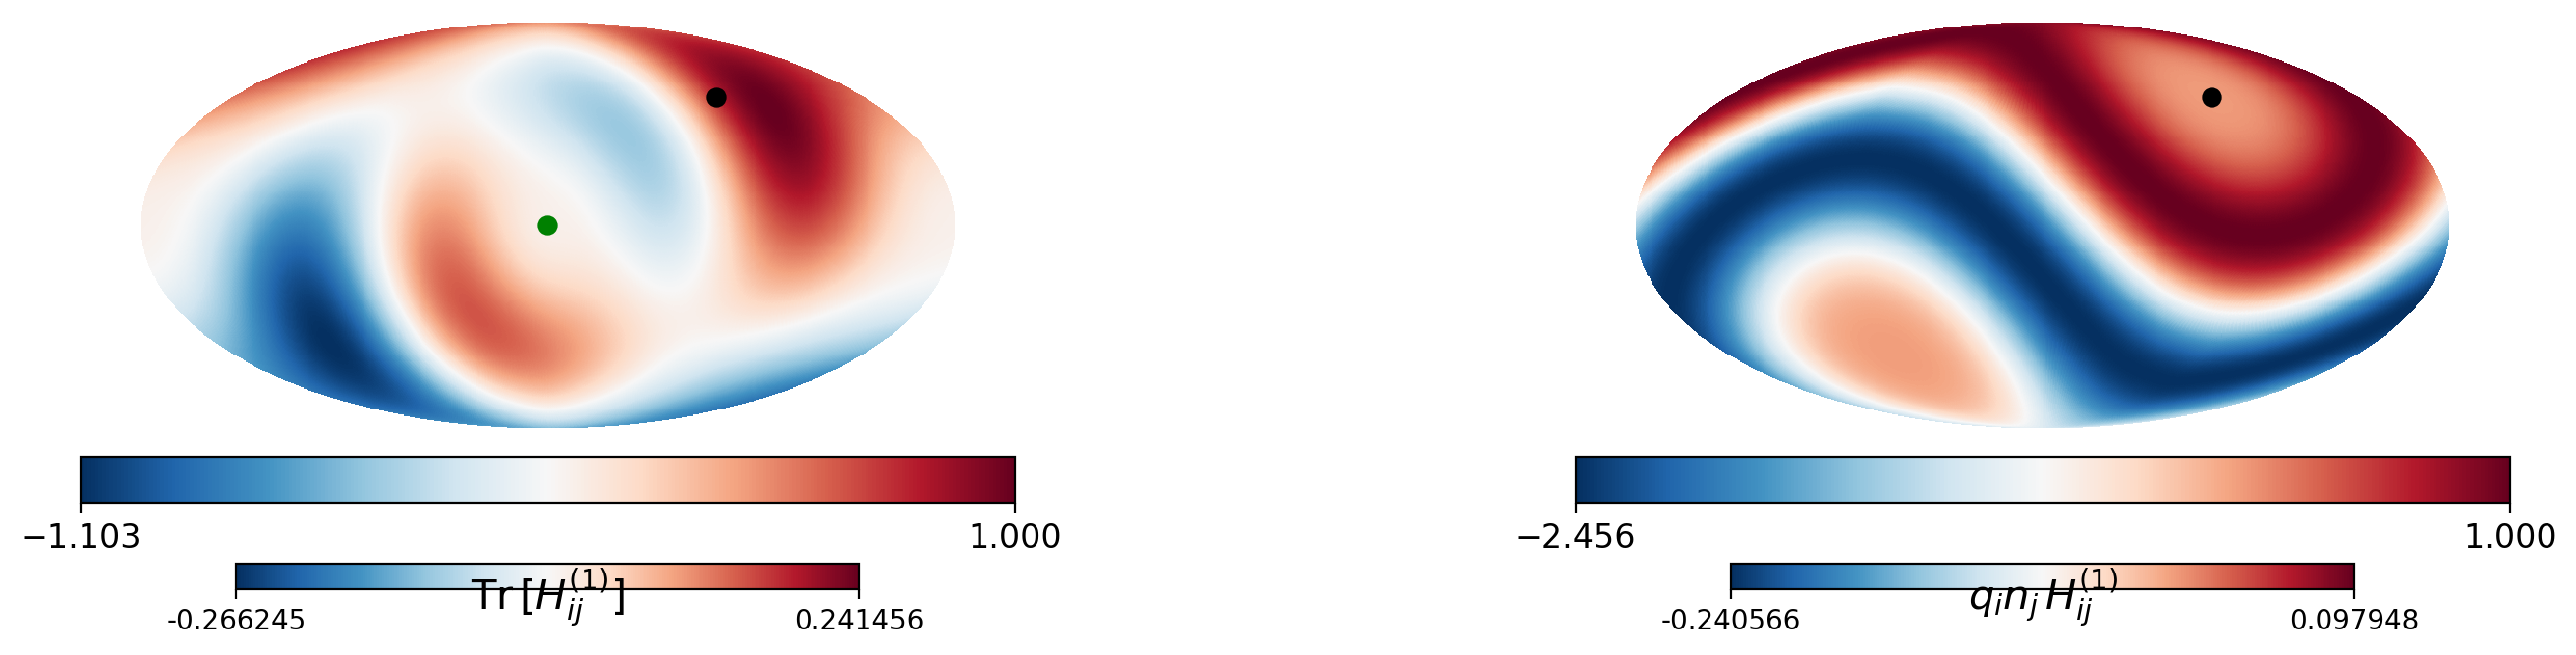

In [6]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,4))

cmap = 'RdBu_r'

fwhm = 0.2

# delta_ij H_ij center
sm = map_stars_dij_center
up_map = hp.ud_grade(map_stars_dij_center,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax1)
hp.mollview(sm,cmap=cmap,cbar=True,title="",hold=True)
# plt.scatter(0,np.pi/4,color='yellow',s=20)
hp.projscatter(theta,phi,color='green',s=40)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathrm{Tr}\,[H^{(1)}_{ij}]$',size=15)

# delta_ij H_ij vcmb
sm = map_stars_dij_v
up_map = hp.ud_grade(map_stars_dij_v,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
plt.axes(ax2)
hp.mollview(sm,cmap=cmap,cbar=True,title="",hold=True)
hp.projscatter(theta0,phi0,color='k',s=40)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$q_i n_j\,H^{(1)}_{ij}$',size=15)


plt.savefig('dipole.pdf',bbox_inches='tight')

In [8]:
# map_stars_dij_v = np.array(map_stars_dij_v)  #hp.remove_monopole(np.array(map_stars_dij_v))

# cls = hp.anafast(map_stars_dij_v)
# ls = np.arange(0,3*nside_stars)

# plt.plot(ls,cls,marker='o')

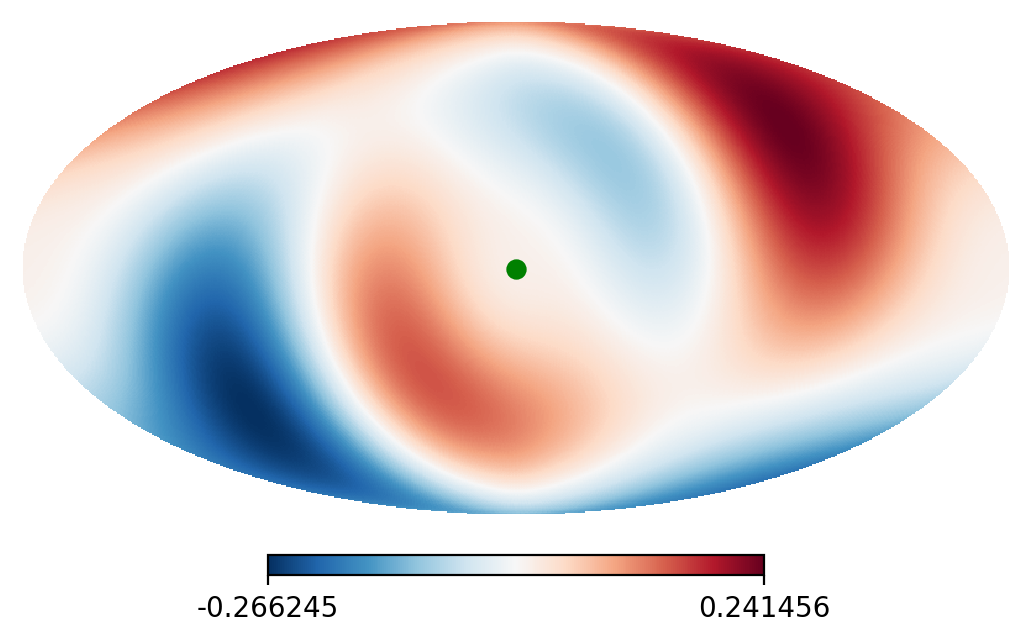

In [11]:
# delta_ij H_ij center
sm = map_stars_dij_center
up_map = hp.ud_grade(map_stars_dij_center,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)

hp.mollview(sm,cmap=cmap,cbar=True,title="",hold=True)
# plt.scatter(0,np.pi/4,color='yellow',s=20)
hp.projscatter(theta,phi,color='green',s=40)
f = plt.gcf()